In [1]:
from fastai.text.all import *

In [2]:
lang = 'de'
model_path = Path(f'{Path(".").absolute()}/data/model')
path = Path('data')
lm_ft_fns = [model_path/f'{lang}_ft', model_path/f'{lang}_ft_vocab']

In [3]:
bs = 64

## Prepare classifier dataset

In [4]:
names = ['text','label','label1,']

In [5]:
df_train = pd.read_csv(path/'germeval2018/germeval2018.training.txt',
                sep ='\t', names=names)

In [6]:
df_train['is_valid'] = False

In [7]:
df_valid = pd.read_csv(path/'germeval2018/germeval2018.test.txt',
                sep ='\t', names=names)

In [8]:
df_valid['is_valid'] = True

In [9]:
df = pd.concat([df_train, df_valid])

## Train model

In [10]:
tok = SentencePieceTokenizer(lang=lang, sp_model=model_path/'spm_de_ft/spm.model')

In [11]:
with open(f'{lm_ft_fns[1]}.pkl', 'rb') as f:
      vocab = pickle.load(f)

In [12]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, vocab=vocab), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader('label'), 
                    splitter=ColSplitter())
dls = dblocks.dataloaders(df)

/home/florian/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [13]:
dls.show_batch()

,text,category
0,"▁xxbos ▁@ machtjanix 23 ▁@ schneeridara ▁@ kr eb bi ▁@ queeniepi ▁@ vergangenheit 17 ▁@ m x lo la 5 ▁@ la z ar us 06 ▁@ lars 959 6 ▁@ heinrich heine 12 ▁@ kokolores 20 ▁@ dunkel denk ▁@ kreativ design 1 ▁@ em ili ac 32 ▁@ die ba ju waren ▁@ lawyerberlin ▁@ s bu nners ▁@ twittonium ▁@ ey svog 3 l ▁@ gun nar _ rich ert ▁@ so rt ex ▁@ loriotfehlt ▁@ nasanasal ▁@ norb inator 2403 ▁@ troll _ putin ▁@ lc 180 ▁xxrep ▁3 ▁6 ▁@ ve spasi anus 69 bc ▁@ xx 7 ni tro 1 xx ▁@ t bg steph en ▁xxmaj ▁dazu ▁braucht ▁es ▁erst ▁einmal ▁eine ▁andere ▁xxmaj ▁ bezeichnung . ▁"" rechts "" ▁ist ▁derart ▁negativ ▁ ko n not iert . ▁xxmaj ▁ich ▁persönlich ▁denke ▁sowieso ▁nicht ▁in ▁diesen ▁xxmaj ▁schublade n ,",OTHER
1,"▁xxbos ▁@ felden f rizz ▁@ wo j tek thomalla ▁@ _ macmike ▁@ nawrat anna ▁@ athin a mala ▁@ charlie _ silve ▁@ pe tpanther 0 ▁@ musta pha mond ah ▁@ sjw _ madbunny ▁@ master m ikeg ▁@ machtjanix 23 ▁@ spadecarrier ▁@ steffmann 45 ▁@ troll _ putin ▁@ norb inator 2403 ▁@ en nof _ ▁@ n ancy peg gym andy ▁@ info 2099 ▁@ life trend ▁@ thomasgbauer ▁@ schmid die maik ▁@ noherrman ▁@ will j rosen blatt ▁@ nasanasal ▁@ ellibisathide ▁@ md _ franz ▁@ youtube ▁xxmaj ▁es ▁war ▁wichtig , ▁zuerst ▁das ▁alte ▁xxmaj ▁europa ▁zu ▁zerstören , ▁da ▁sitzt ▁die ▁meist e ▁xxmaj ▁intelligenz ▁ - ▁ist ▁es ▁völlig ▁zerstört ▁und ▁mit ▁xxup ▁iq ▁90 ▁auf gefüllt , ▁kommt ▁der ▁xxmaj ▁rest ▁dran . ▁xxmaj ▁die ▁machen ▁weniger ▁xxmaj ▁probleme . ▁xxmaj ▁einfach ▁und ▁simpel . ▁ 2",OTHER
2,"▁xxbos ▁xxmaj ▁zum ▁xxmaj ▁ le b zelt en ▁xxmaj ▁ ta ig ▁ n im bt ▁man ▁| lbr | ▁20 ▁xxmaj ▁maß ▁xxmaj ▁ h ö n ig , ▁ 2 ▁xxmaj ▁maß ▁xxmaj ▁wasser , ▁ last s ▁| lbr | ▁ ain ▁ gu ette ▁xxmaj ▁ st und t ▁sie den , ▁xxmaj ▁ge wir z ▁| lbr | ▁da rein , ▁8 ▁halb ▁xxmaj ▁vier ling ▁xxmaj ▁im ber , ▁| lbr | ▁8 ▁mal ▁3 ▁xxmaj ▁lott ▁xxmaj ▁ pfeffer , ▁8 ▁xxmaj ▁lott ▁xxmaj ▁ zi me t , ▁| lbr | ▁8 ▁xxmaj ▁lott ▁xxmaj ▁ mus ga t n us , ▁8 ▁halbe ▁xxmaj ▁lott ▁xxmaj ▁ nä gl , ▁| lbr | ▁ ä nis ▁1 xxunk 2 ▁xxmaj ▁lott , ▁xxmaj ▁ cor ian der ▁1 xxunk 2 ▁xxmaj ▁lott . ▁| lbr | ▁xxmaj ▁di s es",OTHER
3,"▁xxbos ▁@ wo j tek thomalla ▁@ _ macmike ▁@ nawrat anna ▁@ athin a mala ▁@ charlie _ silve ▁@ pe tpanther 0 ▁@ musta pha mond ah ▁@ sjw _ madbunny ▁@ master m ikeg ▁@ machtjanix 23 ▁@ spadecarrier ▁@ steffmann 45 ▁@ troll _ putin ▁@ norb inator 2403 ▁@ en nof _ ▁@ n ancy peg gym andy ▁@ info 2099 ▁@ life trend ▁@ thomasgbauer ▁@ schmid die maik ▁@ noherrman ▁@ will j rosen blatt ▁@ felden f rizz ▁@ nasanasal ▁@ ellibisathide ▁@ md _ franz ▁@ youtube ▁xxmaj ▁ihn ▁direkt ▁könnte ▁man ▁das ▁auch ▁fragen ! ▁xxmaj ▁stattdessen ▁ glo tz en ▁die ▁xxmaj ▁leute ▁lieber ▁ zer str eu ende ▁xxmaj ▁unterhaltung , ▁das ▁ str en gt ▁auch ▁nicht ▁an . ▁xxmaj ▁bildung ▁ist ▁xxmaj ▁arbeit . ▁xxmaj ▁ er ▁hält ▁das ▁xxmaj ▁volk ▁mit ▁ billigen ▁xxmaj ▁spiel",OTHER
4,"▁xxbos ▁@ machtjanix 23 ▁@ norb inator 2403 ▁@ en nof _ ▁@ athin a mala ▁@ troll _ putin ▁@ n ancy peg gym andy ▁@ pe tpanther 0 ▁@ info 2099 ▁@ life trend ▁@ thomasgbauer ▁@ schmid die maik ▁@ charlie _ silve ▁@ noherrman ▁@ will j rosen blatt ▁@ felden f rizz ▁@ nasanasal ▁@ _ macmike ▁@ ellibisathide ▁@ md _ franz ▁xxmaj ▁ oho ▁ - ▁xxmaj ▁be drohung ▁für ▁ein ▁international ▁erhält lich es ▁xxmaj ▁buch ▁ ! lä cher lich . ▁xxmaj ▁passt ▁xxmaj ▁ihnen ▁wohl ▁auch ▁nicht , ▁die ▁xxmaj ▁nach weise ▁aus ▁xxmaj ▁israels ▁xxmaj ▁ geburten abteilung . ▁xxup ▁ps ▁xxmaj ▁ er ▁hat ▁nicht ▁den ▁xxmaj ▁holocaust ▁ge le u g net , ▁den ▁gab ▁es , ▁aber ▁die ▁xxmaj ▁zahl ▁stimmt e ▁nicht , ▁das ▁hat ▁ er ▁nachgewiesen .",OTHER
5,"▁xxbos ▁@ wo j tek thomalla ▁@ _ macmike ▁@ nawrat anna ▁@ athin a mala ▁@ charlie _ silve ▁@ pe tpanther 0 ▁@ musta pha mond ah ▁@ sjw _ madbunny ▁@ master m ikeg ▁@ machtjanix 23 ▁@ spadecarrier ▁@ steffmann 45 ▁@ troll _ putin ▁@ norb inator 2403 ▁@ en nof _ ▁@ n ancy peg gym andy ▁@ info 2099 ▁@ life trend ▁@ thomasgbauer ▁@ schmid die maik ▁@ noherrman ▁@ will j rosen blatt ▁@ felden f rizz ▁@ nasanasal ▁@ ellibisathide 

In [14]:
dls.vocab[1]

['OFFENSE', 'OTHER']

In [15]:
len(dls.train), len(dls.valid)

(78, 54)

In [22]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, pretrained=False, 
                               metrics=[accuracy]).to_native_fp16()
learn.path = model_path

In [23]:
learn.load_encoder(model_path/'de_ft_encoder')

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.004365158267319202)

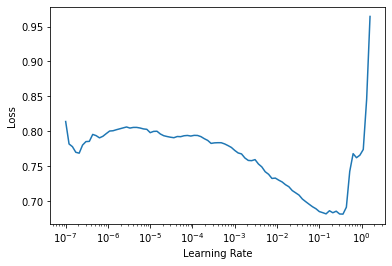

In [18]:
learn.lr_find()

In [24]:
lr = 3e-2

In [25]:
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.600348,0.717281,0.733961,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.517252,0.545358,0.755444,00:04
1,0.450194,0.541568,0.765156,00:04
2,0.332860,0.699287,0.750441,00:04
3,0.219455,0.861101,0.772808,00:04
4,0.146751,0.881636,0.778693,00:04


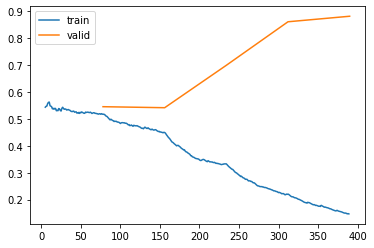

In [26]:
learn.recorder.plot_loss()